# Comparison Between K-nearest Neighbor and Decision Tree Across Adult and Wilt Dataset

# Setup Datasets & Environment

In [ ]:
%matplotlib inline        
# Importing numpy and matplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from sklearn import preprocessing
from IPython.core.debugger import set_trace         #for debugging 
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# For mapping value to color on matplotlib
cmap = cm.autumn
norm = Normalize(vmin=0, vmax=1)

np.set_printoptions(threshold=6)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

#Initialize the random number generator
np.random.seed(1357)

## 1) Adult Dataset

Download and clean the data

      age      workclass    fnlwgt  ... hours-per-week  native-country   label
0      25        Private  226802.0  ...           40.0   United-States   <=50K
1      38        Private   89814.0  ...           50.0   United-States   <=50K
2      28      Local-gov  336951.0  ...           40.0   United-States    >50K
3      44        Private  160323.0  ...           40.0   United-States    >50K
4      34        Private  198693.0  ...           30.0   United-States   <=50K
...    ..            ...       ...  ...            ...             ...     ...
15055  33        Private  245211.0  ...           40.0   United-States   <=50K
15056  39        Private  215419.0  ...           36.0   United-States   <=50K
15057  38        Private  374983.0  ...           50.0   United-States   <=50K
15058  44        Private   83891.0  ...           40.0   United-States   <=50K
15059  35   Self-emp-inc  182148.0  ...           60.0   United-States    >50K

[15060 rows x 15 columns]


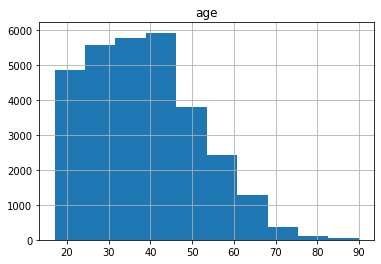

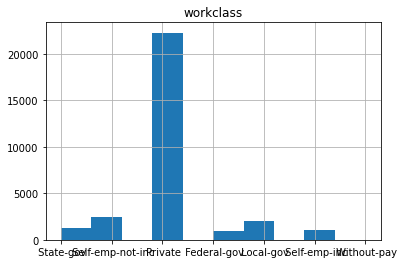

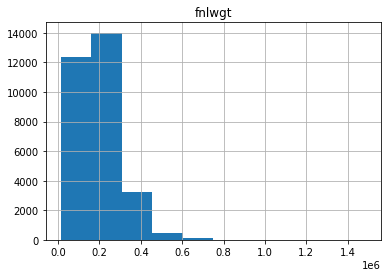

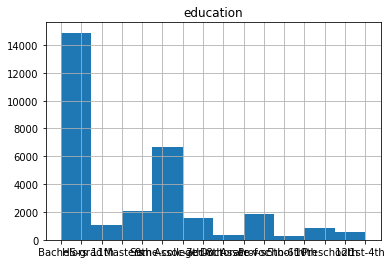

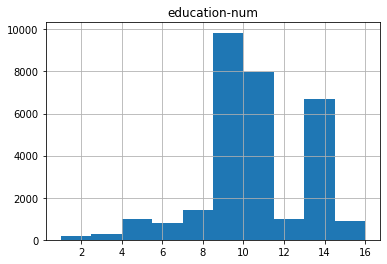

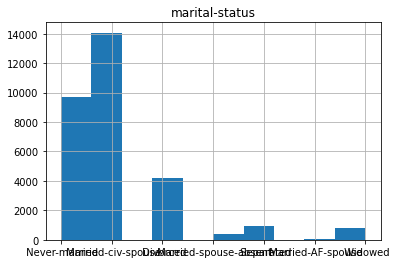

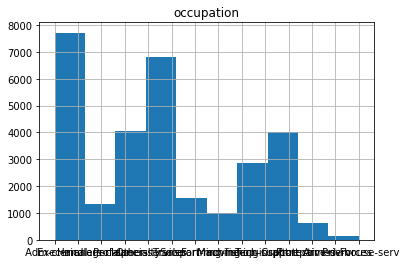

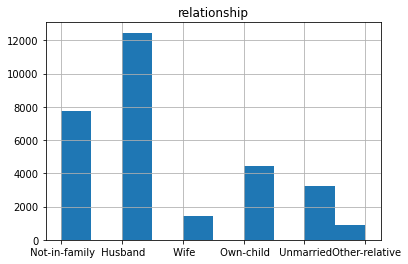

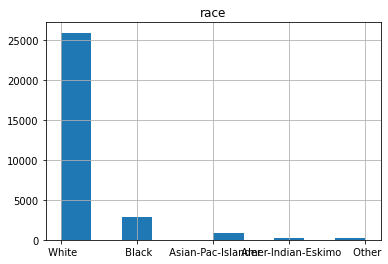

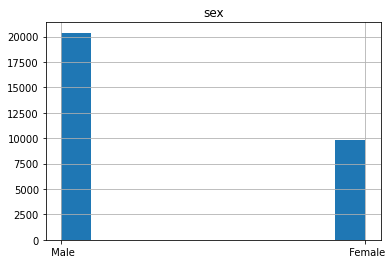

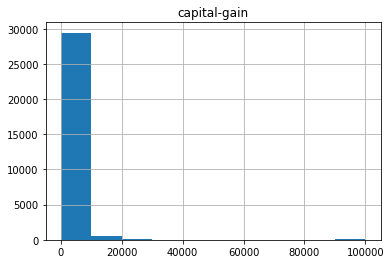

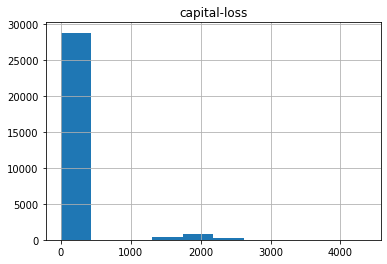

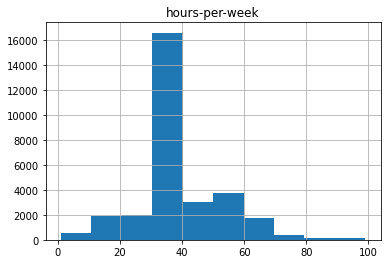

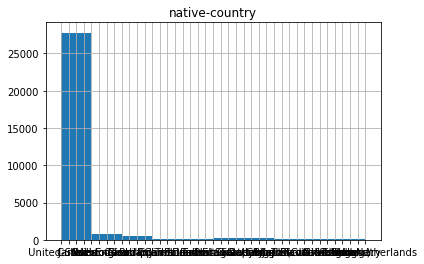

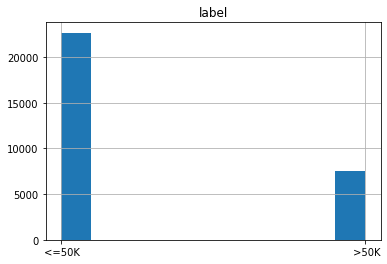

In [ ]:
columns_name = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']

# import data with correct column names
train_adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=columns_name)
test_adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', names=columns_name)

# drop first row that is not data
test_adult.drop(axis=0, index=0, inplace = True)

# Remove rows with missing value (?)
train_adult.replace(to_replace = " ?", value = np.nan, inplace=True)
test_adult.replace(to_replace = " ?", value = np.nan, inplace=True)

test_adult.replace(" <=50K.", " <=50K", inplace=True)
test_adult.replace(" >50K.", " >50K", inplace=True)

train_adult.dropna(inplace=True)
test_adult.dropna(inplace=True)

# Reset the indices
train_adult.reset_index(drop=True, inplace=True)
test_adult.reset_index(drop=True, inplace=True)
print(test_adult)
for s in columns_name:  
  train_adult[s].hist()
  plt.title(s)
  plt.show()


Create one-hot-encoding


In [ ]:
# Create names for options of discrete variables
workclass = [' Private', ' Self-emp-not-inc', ' Self-emp-inc', ' Federal-gov', ' Local-gov', ' State-gov', ' Without-pay', ' Never-worked']
education = [' Bachelors', ' Some-college', ' 11th', ' HS-grad', ' Prof-school', ' Assoc-acdm', ' Assoc-voc', ' 9th', ' 7th-8th', ' 12th', ' Masters', ' 1st-4th', ' 10th', ' Doctorate', ' 5th-6th', ' Preschool']
marital = [' Married-civ-spouse', ' Divorced', ' Never-married', ' Separated', ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse']
occupation = [' Tech-support', ' Craft-repair', ' Other-service', ' Sales', ' Exec-managerial', ' Prof-specialty', ' Handlers-cleaners', ' Machine-op-inspct', ' Adm-clerical', ' Farming-fishing', ' Transport-moving', ' Priv-house-serv', ' Protective-serv', ' Armed-Forces']
relationship = [' Wife', ' Own-child', ' Husband', ' Not-in-family', ' Other-relative', ' Unmarried']
race = [' White', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other', ' Black']
sex = [' Female', ' Male']
country = [' United-States', ' Cambodia', ' England', ' Puerto-Rico', ' Canada', ' Germany', ' Outlying-US(Guam-USVI-etc)', ' India', ' Japan', ' Greece', ' South', ' China', ' Cuba', ' Iran', ' Honduras', ' Philippines', ' Italy', ' Poland', ' Jamaica', ' Vietnam', ' Mexico', ' Portugal', ' Ireland', ' France', ' Dominican-Republic', ' Laos', ' Ecuador', ' Taiwan', ' Haiti', ' Columbia', ' Hungary', ' Guatemala', ' Nicaragua', ' Scotland', ' Thailand', ' Yugoslavia', ' El-Salvador', ' Trinadad&Tobago', ' Peru', ' Hong', ' Holand-Netherlands']
label = [' <=50K', ' >50K']

classes = {'workclass' : workclass, 'education' : education, 'marital-status' : marital, 'occupation' : occupation, 'relationship' : relationship, 'race' : race, 'sex' : sex, 'native-country' : country, 'label' : label}

# replace discrete variable to multiple
for s in classes.keys():
  # create encoder
  enc = preprocessing.OneHotEncoder(categories = [classes[s]])

  # fit data into a 2D array
  transformed = enc.fit_transform(train_adult[s].to_numpy().reshape(-1,1))

  # create a new dataframe with the array
  train_adult_encoded = pd.DataFrame(data=transformed.toarray(), columns = classes[s])

  # concatenate to dataframe
  train_adult = pd.concat([train_adult, train_adult_encoded], axis=1)

  # drop previous variables
  train_adult.drop(s, axis=1, inplace=True)

  # do the same for test set
  enc = preprocessing.OneHotEncoder(categories = [classes[s]])
 
  transformed = enc.fit_transform(test_adult[s].to_numpy().reshape(-1,1))
  test_adult_encoded = pd.DataFrame(data=transformed.toarray(), columns= classes[s])
  test_adult = pd.concat([test_adult, test_adult_encoded], axis=1)
  
  test_adult.drop(s, axis=1, inplace=True)

# find correlation of columns to determine best parameter
correlation = train_adult.corr()
correlation = correlation[' >50K']
correlation = correlation.replace(np.nan, 0.0)
print(correlation)

train_adult = train_adult.to_numpy()

test_adult = test_adult.to_numpy().astype(float)

train_adult_normalized = np.copy(train_adult)
test_adult_normalized = np.copy(test_adult)
# normalize data set
x, y = train_adult.shape
max_train = np.amax(train_adult_normalized,axis=0)
min_train = np.amin(train_adult_normalized,axis=0)
max_test = np.amax(test_adult_normalized,axis=0)
min_test = np.amin(test_adult_normalized,axis=0)
for i in range(0,y):
  if (max_train[i] > min_train[i]): #ensure there are no division by 0
    train_adult_normalized[:,i] = (train_adult_normalized[:,i] - min_train[i])/(max_train[i]-min_train[i])
  if (max_test[i] > min_test[i]): #ensure there are no division by 0
    test_adult_normalized[:,i] = (test_adult_normalized[:,i] - min_test[i])/(max_test[i]-min_test[i])

age                    0.241998
fnlwgt                -0.008957
education-num          0.335286
capital-gain           0.221196
capital-loss           0.150053
                         ...   
 Peru                 -0.013300
 Hong                  0.003883
 Holand-Netherlands   -0.003315
 <=50K                -1.000000
 >50K                  1.000000
Name:  >50K, Length: 107, dtype: float64


## 2) Wilt Datasets

- Download the zip file and get the csv
- Clean the data and convert strings to floating point data. 
- Encode the clasess

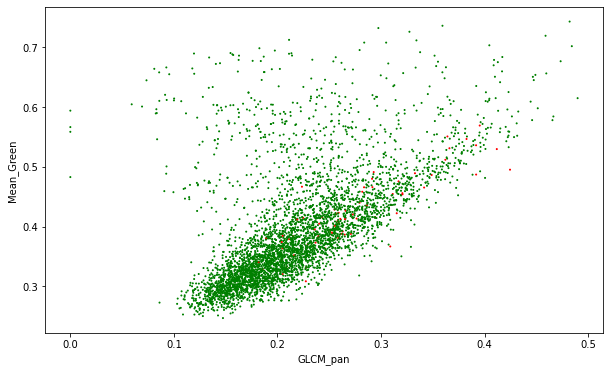

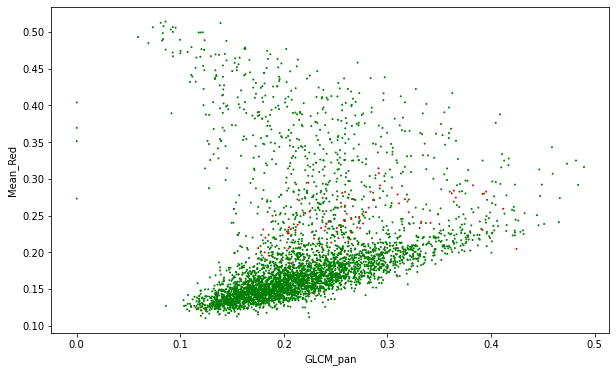

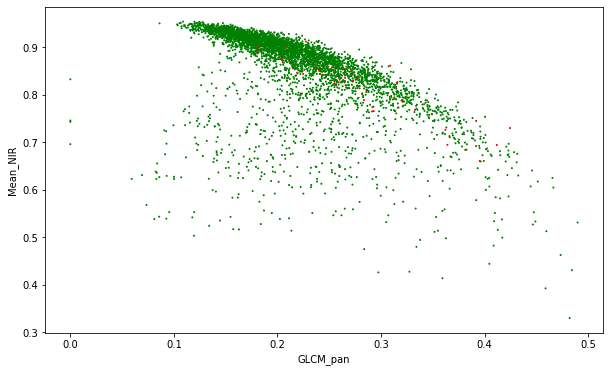

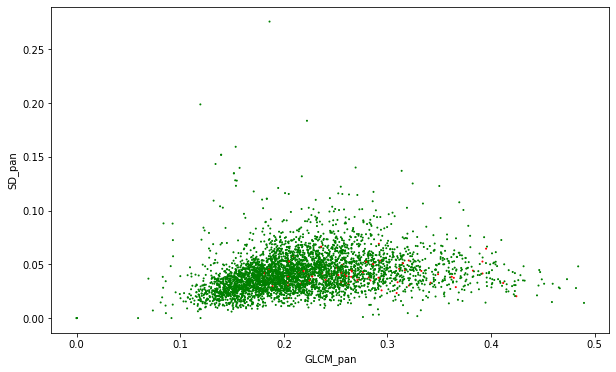

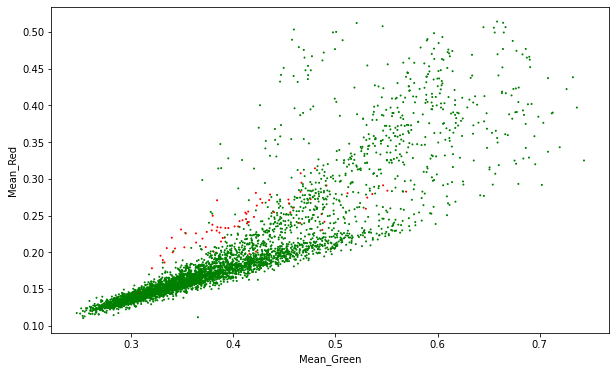

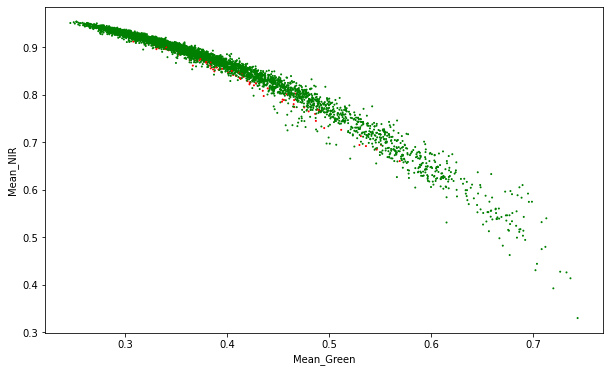

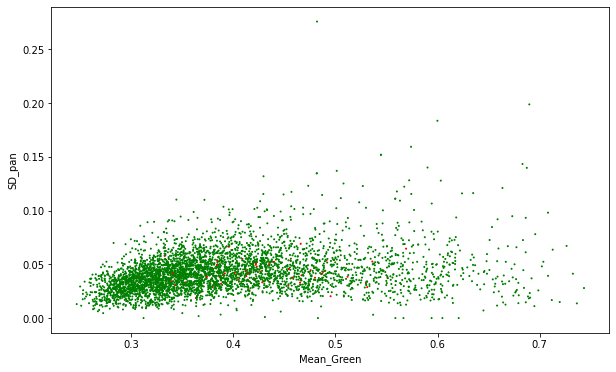

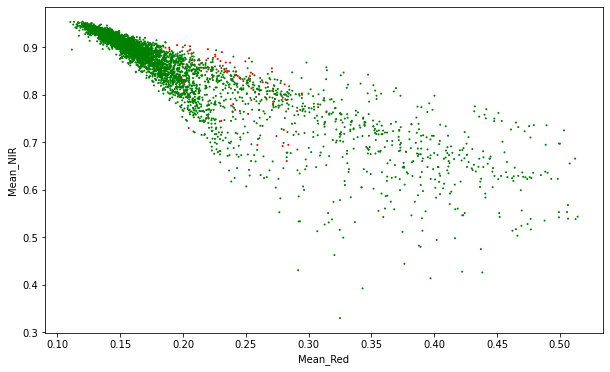

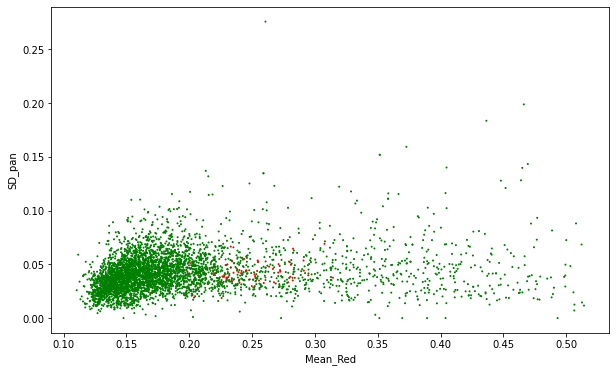

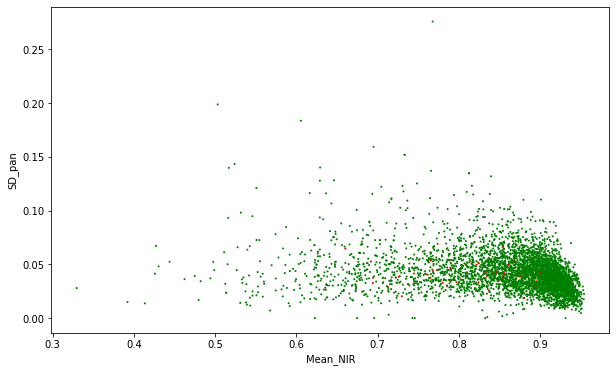

[[0 0.2251120577286484 0.34873702939488854 0.15748697698829894
  0.8937219350834069 0.06454456308520355]
 [0 0.23070090299041957 0.3523462193632143 0.15847583282129252
  0.891592006301776 0.050777354895920654]
 [0 0.2138553685274019 0.3923657322710065 0.21442950867099503
  0.866023402850274 0.06586702527208688]
 ...
 [0 0.2350125036220021 0.3900970688631682 0.17298544549852307
  0.8723718280824961 0.040457746098420296]
 [0 0.2842803608563352 0.4252615901080976 0.18092817754058885
  0.8390923771491834 0.03906703971505999]
 [0 0.2667213804033189 0.48041517016042884 0.2626101216727382
  0.7888740424446776 0.0823081931978642]] <class 'numpy.ndarray'>


In [ ]:
# Download and load the csv from the zip files
wilt_columns_names = ['class', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']
resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00285/wilt.zip")
zipfile = ZipFile(BytesIO(resp.read()))
train_wilt = pd.read_csv(zipfile.open('training.csv'), names=wilt_columns_names).to_numpy()[1:]
test_wilt = pd.read_csv(zipfile.open('testing.csv'), names=wilt_columns_names).to_numpy()[1:]

# Encode the wilt labels
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_wilt[:,0])
train_wilt[:,0] = label_encoder.transform(train_wilt[:,0]).astype(int)
test_wilt[:,0] = label_encoder.transform(test_wilt[:,0]).astype(int)
# Convert the string to float 
train_wilt[:,1:] = preprocessing.normalize(train_wilt[:,1:]).astype(np.float)
test_wilt[:,1:] = preprocessing.normalize(test_wilt[:,1:]).astype(np.float)

np.random.shuffle(train_wilt)
color = [ 'green' if item == 0 else 'red' for item in train_wilt[:,0]]

def plotdata(i,j):
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.scatter(train_wilt[:,i],train_wilt[:,j], s=1, color=color)
  plt.xlabel(wilt_columns_names[i])
  plt.ylabel(wilt_columns_names[j])
  plt.show()

for i in range(1,len(wilt_columns_names)):
  for j in range(i,len(wilt_columns_names)):
    if (i==j): 
      continue
    plotdata(i,j)

print(train_wilt, type(train_wilt))

In [ ]:
#helper function for rule of thumb of cross-validation

def optimal_hyperparameter(mean, std):
  min_index = 0
  min_value = mean[0]
  # find smallest mean value
  for i in range(1, len(mean)-1):
    if (mean[i] < min_value):
      min_value = mean[i]
      min_index = i

  optimal = min_index
  # find smallest parameter with 1 std of min_mean
  for i in range (0, min_index):
    if (mean[i]-std[i] <= min_value):
      optimal = i
      break
  print('Optimal hyperparamer : ', optimal+1)
  return optimal+1

# KNN

Initialize the cross validation knn function

In [ ]:
def cross_validation_knn(data, k_range, dataset):
  training_segments = np.array_split(data, 5)
  average_errors, errors_std = [], []
  for k in k_range:
    cv_errors=[]
    for i in range(5):
      # create the training and validation dataset
      training_set = np.concatenate(tuple(np.delete(training_segments,i,axis=0)))
      validation_set = training_segments[i]

      if (dataset == "wilt"):
        training_x, training_labels = training_set[:,1:], training_set[:,0].astype(int)
        validation_x,validation_labels = validation_set[:,1:],validation_set[:,0].astype(int)
      elif (dataset == "adult"):
        training_x, training_labels = training_set[:,:-2], training_set[:,-1].astype(int)
        validation_x,validation_labels = validation_set[:,:-2],validation_set[:,-1].astype(int)
      else:
        return

      # Initialize the knn class
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(training_x, training_labels) # feed the training data 
      prediction_labels = knn.predict(validation_x) # make the prediction on the validation data set
      # prediction_labels = np.argmax(prediction_prob,axis=1) 
      cv_errors.append(np.mean(prediction_labels != validation_labels))
    average_errors.append(np.mean(cv_errors)) # add the accuracy into the data
    errors_std.append(np.std(cv_errors))
  return average_errors, errors_std



### 1) Adult Dataset

Perform Cross Validation to find best K

Best K found was k = 19


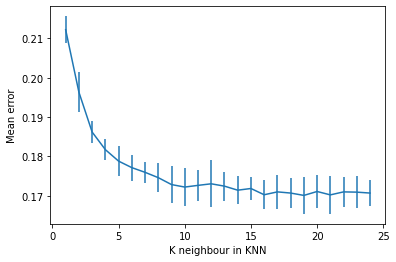

In [ ]:
k_range = range(1,25)
average_errors, errors_std = cross_validation_knn(train_adult_normalized, k_range, "adult")
plt.errorbar(k_range, average_errors, errors_std)
plt.xlabel('K neighbour in KNN')
plt.ylabel('Mean error')
adult_best_k_value = optimal_hyperparameter(average_errors, errors_std)
print(f'Best K found was k = {adult_best_k_value}')

Optimal hyperparamer :  9
Best K found was k = 9


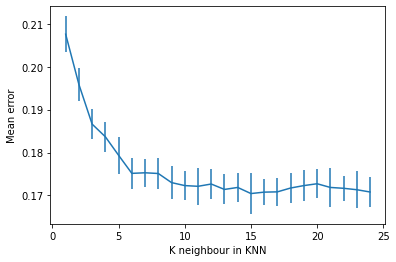

In [ ]:
# test with scaling by correlation^2 => actually doesn't increase accuracy by much
x, y = train_adult_normalized.shape
for i in range(0,y):
  train_adult_normalized[:,i] = train_adult_normalized[:,i]*(correlation.to_numpy()[i])**2
  test_adult_normalized[:,i] = test_adult_normalized[:,i]*(correlation.to_numpy()[i])**2

k_range = range(1,25)
average_errors, errors_std = cross_validation_knn(train_adult_normalized, k_range, "adult")
plt.errorbar(k_range, average_errors, errors_std)
plt.xlabel('K neighbour in KNN')
plt.ylabel('Mean error')
adult_best_k_value = optimal_hyperparameter(average_errors, errors_std)
print(f'Best K found was k = {adult_best_k_value}')

Scaling with correlation didn't change the accuracy.
Run the best model on various portion of data size

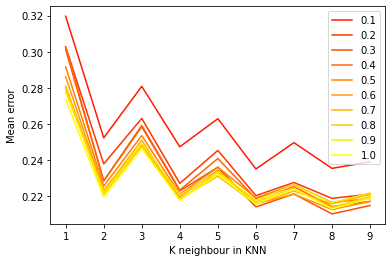

In [ ]:
data_percent_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
k_range = range(1,10)
plt.xlabel('K neighbour in KNN')
plt.ylabel('Mean error')
for percentage in data_percent_range:
  # Extract a portion of the total data
  max_index = int(np.floor((train_adult.shape[0]-1) * percentage))
  average_errors, _ = cross_validation_knn(train_adult[0:max_index,:], k_range, "adult")
  plt.errorbar(k_range, average_errors, label=percentage, color = cmap(norm(percentage)))
plt.legend()
plt.title = 'Data Amount Vs Error Rate'

Run the best model on the testing data set.

In [ ]:
best_adult_KNN = KNeighborsClassifier(n_neighbors=adult_best_k_value)
best_adult_KNN.fit(train_adult_normalized[:,:-2], train_adult_normalized[:,-1])

prediction_labels = best_adult_KNN.predict(test_adult_normalized[:,:-2])
adult_final_knn_error = np.mean(prediction_labels != test_adult_normalized[:,-1])
print(f'Error of adult dataset from best KNN model is {adult_final_knn_error}')

Error of adult dataset from best KNN model is 0.1738379814077025


### 2) Wilt Dataset

Perform Cross Validation to find best K

Optimal hyperparamer :  6
Best K found was k = 1


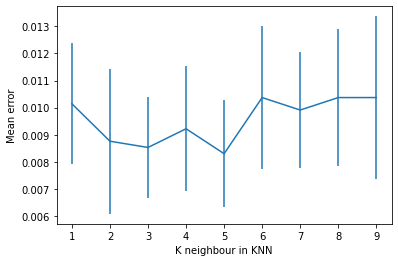

In [ ]:
k_range = range(1,10)
average_errors, errors_std = cross_validation_knn(train_wilt, range(1,10), "wilt")
plt.errorbar(k_range, average_errors, errors_std)
plt.xlabel('K neighbour in KNN')
plt.ylabel('Mean error')
wilt_best_k_value = optimal_hyperparameter(average_errors, errors_std)
print(f'Best K found was k = {wilt_best_k_value}')

Run the best model on various portion of data size

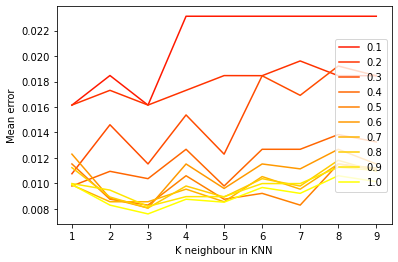

In [ ]:
data_percent_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
k_range = range(1,10)
plt.xlabel('K neighbour in KNN')
plt.ylabel('Mean error')
for percentage in data_percent_range:
  # Extract a portion of the total data
  max_index = int(np.floor((train_wilt.shape[0]-1) * percentage))
  average_errors, _ = cross_validation_knn(train_wilt[0:max_index,:], k_range, "wilt")
  plt.errorbar(k_range, average_errors, label=percentage, color = cmap(norm(percentage)))
plt.legend(loc="right")
plt.title = 'Data Amount Vs Error Rate'

Run the best model on the testing data set.

In [ ]:
best_wilt_KNN = KNeighborsClassifier(n_neighbors=wilt_best_k_value)
best_wilt_KNN.fit(train_wilt[:,1:],train_wilt[:,0].astype(np.int))

prediction_labels = best_wilt_KNN.predict(test_wilt[:,1:])
wilt_final_knn_error = np.mean(prediction_labels.astype(np.int) != test_wilt[:,0].astype(np.int))
print(f'Error of wilt from best KNN model is {wilt_final_knn_error}')

Error of wilt from best KNN model is 0.194


# Decision Trees


## 1) Adult Dataset

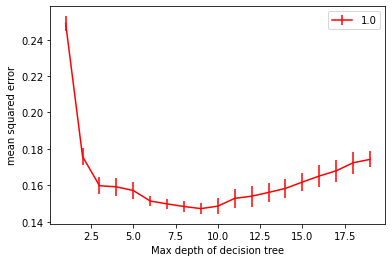

In [ ]:
training_segments = np.array_split(train_adult, 5)
depth_range = range(1,20)

def crossValidation(data_percentage):
  square_error = []
  std_deviation = []

  for depth in depth_range:
    prediction_array = []
    for i in range(5):
      # create the training and validation dataset
      training_set = np.concatenate(tuple(np.delete(training_segments,i)))
      validation_set = training_segments[i]

      # keep validation_percentage of the validation set
      np.random.shuffle(validation_set)
      max_index = int(np.floor(validation_set.size*data_percentage)) # get max_index*data_percentage
      validation_set = validation_set[0:max_index, :]

      # keep validation_percentage of the training set
      np.random.shuffle(training_set)
      max_index = int(np.floor(training_set.size*data_percentage)) # get max_index*data_percentage
      training_set = training_set[0:max_index, :]

      training_x, training_labels= training_set[:, 0:-2], training_set[:,-1]
      validation_x,validation_labels = validation_set[:,0:-2],validation_set[:,-1]

      # Fit the data into a decision tree
      dtree_model = DecisionTreeClassifier(max_depth=depth)
      dtree_model.fit(training_x, training_labels) # feed the training data 
      prediction_prob = dtree_model.predict(validation_x) # make the prediction on the validation data set   

      prediction_array.append(np.mean(prediction_prob != validation_labels))

    square_error.append(np.mean(prediction_array)) # add the accuracy mean and std into the data
    std_deviation.append(np.std(prediction_array))
  return square_error, std_deviation

def plotCrossValidation(col, tup, lab):
  mean, std = tup
  plt.errorbar(depth_range, mean, std, label=lab, color = col)
  plt.xlabel('Max depth of decision tree')
  plt.ylabel('mean squared error')
  plt.legend()
  
plotCrossValidation('r', crossValidation(1.0), '1.0')


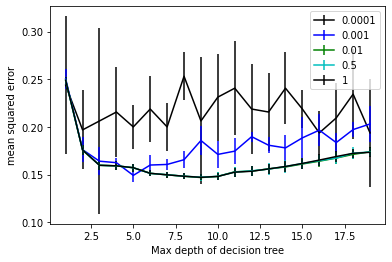

In [ ]:
# Testing for different percentage size of training/validation set

plotCrossValidation('k', crossValidation(0.0001), '0.0001')
plotCrossValidation('b', crossValidation(0.001), '0.001')
plotCrossValidation('g', crossValidation(0.01), '0.01')
plotCrossValidation('c', crossValidation(0.5), '0.5')
plotCrossValidation('k', crossValidation(1.0), '1')

This is clear from the plot that selectionning fewer rows of the validation set leads to greater variation of the mean error of the 5-fold cross validation. It is less predictable what the mean square error will be for different hyperparameters. Now we can see the error on the test data set using the best max_depth hyperparameter.

In [ ]:
mean, std = crossValidation(1.0)
optimal_max_depth = optimal_hyperparameter(mean, std)
training_set = train_adult
training_x, training_labels= training_set[:, 0:-2], training_set[:,-1]

test_set = test_adult
test_x , test_labels = test_set[:,0:-2], test_set[:,-1]

# create decision tree
dtree_model = DecisionTreeClassifier(max_depth=optimal_max_depth)
dtree_model.fit(training_x, training_labels) # feed the training data 

prediction_prob = dtree_model.predict(test_x) # make the prediction on the test data set 

adult_final_decision_tree_error = np.mean(prediction_prob != test_labels)
print(f'Final error for decision tree in the adult dataset is {adult_final_decision_tree_error}')
print(f'Standard deviation {np.std(prediction_prob != test_labels)}')


Optimal hyperparamer :  7
Final error for decision tree in the adult dataset is 0.149136786188579
Standard deviation 0.35622325189959325


## 2) Wilt Dataset

Perform cross validation on the wilt data set

In [ ]:
def cross_validation_decision_tree(data, depth_range):
  training_segments = np.array_split(data, 5)
  average_errors, errors_std = [], []

  for depth in depth_range:
    cv_errors=[]
    for i in range(5):
      # create the training and validation dataset
      training_set = np.concatenate(tuple(np.delete(training_segments,i,axis=0)))
      validation_set = training_segments[i]
      # extract the label and data
      training_x, training_labels= training_set[:, 1:], training_set[:,0].astype(int)
      validation_x,validation_labels = validation_set[:,1:],validation_set[:,0].astype(int)
      # Fit the data into a decision tree
      dtree_model = DecisionTreeClassifier(max_depth=depth)
      dtree_model.fit(training_x, training_labels) # feed the training data 
      prediction_prob = dtree_model.predict(validation_x) # make the prediction on the validation data set   
      cv_errors.append(np.mean(prediction_prob != validation_labels))
    average_errors.append(np.mean(cv_errors)) # add the error mean and std into the data
    errors_std.append(np.std(cv_errors))
  return average_errors, errors_std

Perform Cross Validation to get the best depth hyperparameter.

Best Depth is d = 12


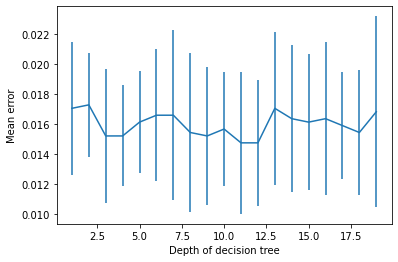

In [ ]:
depth_range = range(1,20)
average_errors, errors_std = cross_validation_decision_tree(train_wilt, depth_range)
plt.errorbar(depth_range, average_errors, errors_std)
plt.xlabel('Depth of decision tree')
plt.ylabel('Mean error')
# using rule of thumb is really bad here because of high standard deviations, so just take smallest
best_wilt_depth = np.argmin(average_errors)+1

print(f'Best Depth is d = {best_wilt_depth}')

Test the result for different data size

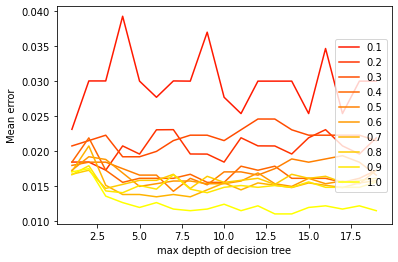

In [ ]:
data_percent_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
depth_range = range(1,20)
plt.xlabel('max depth of decision tree')
plt.ylabel('Mean error')
for percentage in data_percent_range:
  # Extract a portion of the total data
  max_index = int(np.floor((train_wilt.shape[0]-1) * percentage))
  average_errors, _ = cross_validation_decision_tree(train_wilt[0:max_index,:], depth_range)
  plt.errorbar(depth_range, average_errors, label=percentage, color = cmap(norm(percentage)))
plt.legend(loc='right')
plt.title = 'Data Amount Vs Error Rate'

Build the tree model with the best hyperparameters

In [ ]:
best_wilt_decision_tree = DecisionTreeClassifier(max_depth=best_wilt_depth)
wilt_training_data, wilt_training_label = train_wilt[:,1:], train_wilt[:,0].astype(int)
best_wilt_decision_tree.fit(wilt_training_data,wilt_training_label)
# make the prediction on the test data set   
prediction_prob = best_wilt_decision_tree.predict(test_wilt[:,1:]).astype(int)
wilt_final_decision_tree_error = np.mean(prediction_prob!=test_wilt[:,0].astype(int))
print(f'Error of wilt from best decision tree is {wilt_final_decision_tree_error}')

Error of wilt from best decision tree is 0.24


# Compare the final results

## Adult

Error of adult from best KNN model is 0.1738379814077025
Error of adult from best decision tree is 0.149136786188579


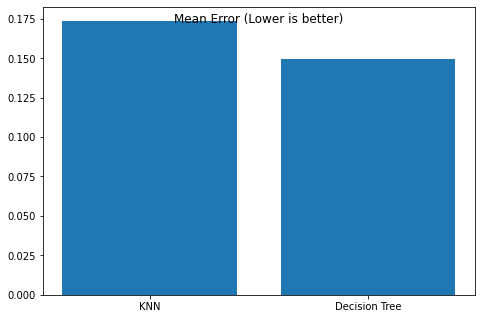

In [ ]:
print(f'Error of adult from best KNN model is {adult_final_knn_error}')
print(f'Error of adult from best decision tree is {adult_final_decision_tree_error}')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.suptitle('Mean Error (Lower is better)')
langs = ['KNN', 'Decision Tree']
students = [adult_final_knn_error, adult_final_decision_tree_error]
ax.bar(langs,students)
plt.show()

## Wilt

Error of wilt from best KNN model is 0.194
Error of wilt from best decision tree is 0.24


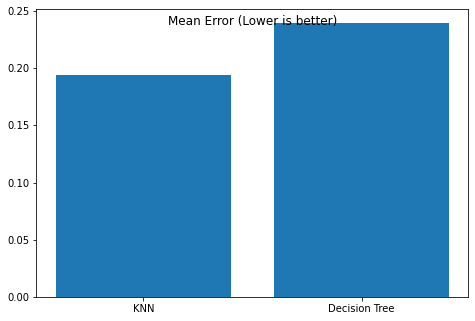

In [ ]:
print(f'Error of wilt from best KNN model is {wilt_final_knn_error}')
print(f'Error of wilt from best decision tree is {wilt_final_decision_tree_error}')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.suptitle('Mean Error (Lower is better)')
langs = ['KNN', 'Decision Tree']
students = [wilt_final_knn_error,wilt_final_decision_tree_error]
ax.bar(langs,students)
plt.show()